# Starter Code for ECE 580 HW2

Demo code for solving LASSO:
$$\arg\min_w \|Y - Xw\|_2^2 + \alpha \|w\|_1$$ 

In [36]:
import torch
# lasso code
from sklearn.linear_model import Lasso

torch.manual_seed(0)
X = torch.randn(4,6)   # 4 samples, 6 features
Y = torch.randn(4)     # Target variable

# Set the regularization strength alpha = 10
myalpha = 0.01

# Fit the Lasso model
lasso = Lasso(alpha=myalpha, fit_intercept=False, max_iter=10000)
lasso.fit(X.numpy(), Y.numpy())

# Display the coefficients
print("Target:", Y)
print("X:", X)
print("w:", lasso.coef_)
print("\033[91mNote: if alpha is unspecified, sklearn.linear_model.Lasso defaults to alpha=1.0 \033[0m")


Target: tensor([0.3704, 1.4565, 0.9398, 0.7748])
X: tensor([[-1.1258, -1.1524, -0.2506, -0.4339,  0.8487,  0.6920],
        [-0.3160, -2.1152,  0.4681, -0.1577,  1.4437,  0.2660],
        [ 0.1665,  0.8744, -0.1435, -0.1116,  0.9318,  1.2590],
        [ 2.0050,  0.0537,  0.6181, -0.4128, -0.8411, -2.3160]])
w: [ 0.6800222  -0.12440585  0.         -0.3782028   0.9276224  -0.        ]
Note: if alpha is unspecified, sklearn.linear_model.Lasso defaults to alpha=1.0 


Possibly handy function for rasterizing images: torch.reshape()

In [37]:
torch.manual_seed(0)
v = torch.randn(4,8)
print('initial shape of v: ', v.shape)
v_vec = v.reshape(32)
print('after reshaping v: ', v_vec.shape)
print('verify that v==v.reshape(4,8).reshape(32): ', (v-v_vec.reshape(4,8)).norm().item())

initial shape of v:  torch.Size([4, 8])
after reshaping v:  torch.Size([32])
verify that v==v.reshape(4,8).reshape(32):  0.0


Code for loading image

Grayscale Image Shape: torch.Size([200, 192])


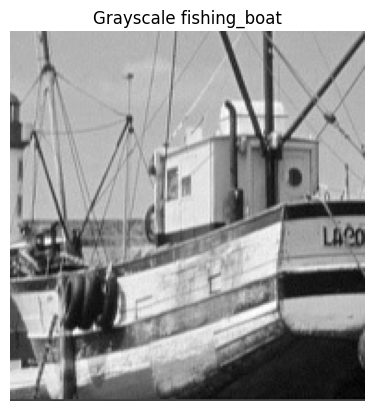

Grayscale image saved to grayscale_fishing_boat.bmp


In [38]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
# Load the BMP image using PIL
image_path = "fishing_boat.bmp"  # Replace with your BMP file path
original_image = Image.open(image_path)

# Convert to grayscale using torchvision transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to 1-channel grayscale
    transforms.ToTensor()  # Convert to a PyTorch tensor
])
# Apply the transform
grayscale_image = transform(original_image)[0,:,:]

# Check the shape of the grayscale image tensor
print("Grayscale Image Shape:", grayscale_image.shape)

plt.imshow(grayscale_image, cmap="gray")  # Use cmap="gray" for grayscale display
plt.title("Grayscale fishing_boat")
plt.axis("off")  # Remove axis for better visualization
plt.show()

# Save the grayscale image as a BMP for verification (optional)
save_path = "grayscale_fishing_boat.bmp"
transforms.ToPILImage()(grayscale_image).save(save_path)
print(f"Grayscale image saved to {save_path}")

# Question 1

## a).

In [39]:
# Recall from HW1, our proposed model included adding a constant term to the input

# load dataste
X_train, y_train, _, _ = torch.load('../HW1/cleaned_automobile_train_dataset.pt').values()
X_test, y_test, _, _ = torch.load('../HW1/cleaned_automobile_test_dataset.pt').values()

# Add a constant term to the input
X_train = torch.cat((X_train, torch.ones(X_train.shape[0], 1)), dim=1).cpu().numpy()
X_test = torch.cat((X_test, torch.ones(X_test.shape[0], 1)), dim=1).cpu().numpy()


from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Perform 6-fold cross-validation
results = cross_validate(model, X_train, y_train, cv=6, scoring='neg_mean_squared_error')

mses = results['test_score'] * -1
average_mses = mses.mean()

print(f'{mses=}')
print(f'{average_mses=}')

mses=array([ 9677476. , 16784012. ,  7996756.5,  7787531.5, 10094987. ,
       15623169. ])
average_mses=np.float64(11327322.0)


Reported MSES: 9677476, 16894012, 7996756.5, 7787531.5, 10094987, 15623169
Reported Average MSE: 11327322

We see that there are quite some descripencies depending the choice of validation sets, especially in the scenario of limited data.

## b).

In [ ]:
# first compute regular linear regression
linear = LinearRegression()
linear.fit(X_train, y_train)
beta = linear.coef_

# find the l2norm of beta
l2norm = torch.tensor(beta).norm()
norm_low = 0.1 * l2norm
norm_high = 0.5 * l2norm

from sklearn.linear_model import Ridge
import numpy as np
# select lambda in a logarithmic scale
norms = []
for λ in 50 / 2**np.linspace(0, 9, 10):
    ridge = Ridge(λ)
    ridge.fit(X_train, y_train)
    beta = ridge.coef_
    l2norm = torch.tensor(beta).norm()
    if norm_low <= l2norm <= norm_high:
        print(f'{λ=}, {l2norm=}, {norm_low=}, {norm_high=}')
    norms.append((λ, l2norm))
        
    


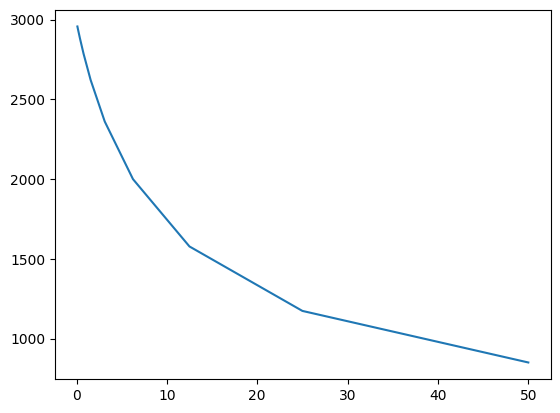

In [42]:
from matplotlib import pyplot as plt

lams, l2norms = zip(*norms)
plt.plot(lams, l2norms)

## c).

In [ ]:
res_train = []
res_test = []
for lam in lams:
    # Perform 6-fold cross-validation
    ridge = Ridge(lam)
    results = cross_validate(ridge, X_train, y_train, cv=6, scoring='neg_mean_squared_error', return_train_score=True)
    train_mses = results['train_score'] * -1
    test_mses = results['test_score'] * -1
    res_train.append(train_mses.mean())
    res_test.append(test_mses.mean())

    

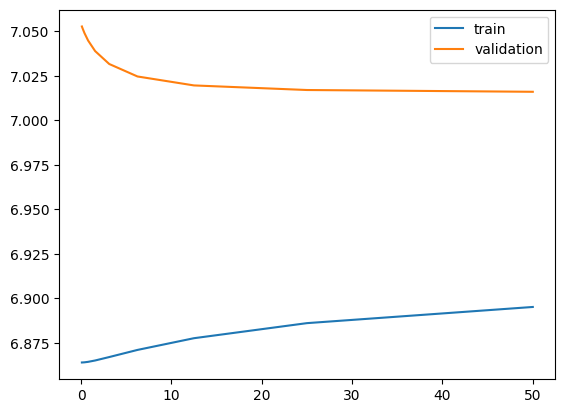

In [44]:
plt.plot(lams, np.log10(res_train), label='train')
plt.plot(lams, np.log10(res_test), label='validation')
plt.legend()

We see that as lambda increases, although the training mse increases, the validation mse actually decreases, closing the gap between training and validation sets.

## d).

In [45]:
lam_star = 50

# this choice made based on validation error is different from the one made based on the train error. 
ridge = Ridge(lam_star)
ridge.fit(X_train, y_train)
y_hat = ridge.predict(X_test)
if y_test.device != 'cpu':
    y_test = y_test.cpu().numpy()
mse = ((y_hat - y_test)**2).mean()

print(f'test_{mse=}')

# 6-fold cross-validation
from sklearn.model_selection import cross_val_score
cross_score = cross_val_score(ridge, X_train, y_train, cv=6, scoring='neg_mean_squared_error')
cross_mse = -cross_score
print(f'{cross_mse=}')

test_mse=np.float32(194545970.0)
cross_mse=array([ 9994327.,  9460999.,  7936231.,  8400108.,  9928843., 16531553.])


## e).

In [46]:
# pick largest lambda
lams = 3000000 / 2**np.linspace(0, 9, 10)

if y_train.device != 'cpu':
    y_train = y_train.cpu().numpy()

for lam in lams:
    lasso = Lasso(lam)
    lasso.fit(X_train, y_train)
    w = np.linalg.norm(lasso.coef_)
    print(w)

0.0
5.7737513
8.676704
10.128181
11.009962
11.5499115
11.829032
46.624863
68.739136
80.1849


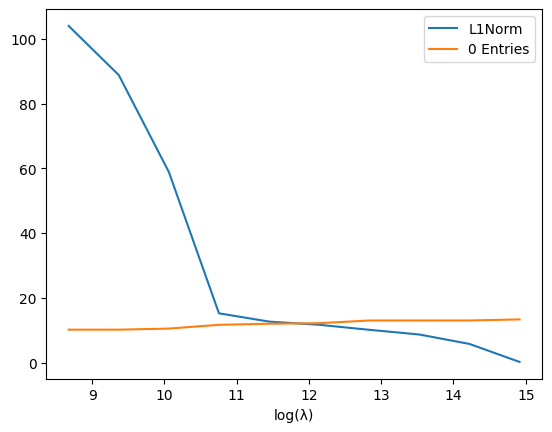

In [47]:
# λs = 3000000 / 2**np.linspace(0, 9, 10)
from sklearn.linear_model import Lasso

ws = []
zeros = []
for lam in lams:
    lasso = Lasso(lam)
    # cross validation
    cross_result = cross_validate(lasso, X_train, y_train, cv=6, scoring='neg_mean_squared_error', return_estimator=True)
    # cross_mses = -cross_result['test_score']
    # print(f'{cross_mses.mean()=}')
    # mses.append(cross_mses.mean())
    # estimators = cross_result['estimator']
    estimators = cross_result['estimator']
    w = [np.linalg.norm(est.coef_, 1) for est in estimators]
    zero = [np.sum(est.coef_ == 0) for est in estimators]
    ws.append(np.mean(w))
    zeros.append(np.mean(zero))
    

plt.plot(np.log(lams), ws, label='L1Norm')
plt.plot(np.log(lams), zeros, label='0 Entries')
plt.xlabel('log(λ)')
plt.legend()
    

## f).

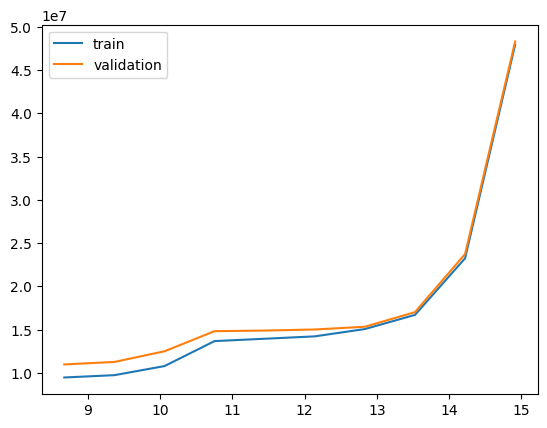

In [48]:
train_mses = []
test_mses = []
for lam in lams:
    lasso = Lasso(lam)
    results = cross_validate(lasso, X_train, y_train, cv=6, scoring='neg_mean_squared_error', return_estimator=True, return_train_score=True)
    train_mse = -results['train_score']
    test_mse = -results['test_score']
    train_mses.append(train_mse.mean())
    test_mses.append(test_mse.mean())
    
plt.plot(np.log(lams), train_mses, label='train')
plt.plot(np.log(lams), test_mses, label='validation')
plt.legend()
    
    

## g).

the 4th lambda (187500) was chosen because while it has some descent train/validation accuracy, it had very small gap between train and validation dataset

In [49]:
# best lambda
lam_star = lams[4]
print(f'{lam_star=}')

lasso = Lasso(lam_star)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)
mse = ((y_hat - y_test)**2).mean()
print(f'{mse=}')

# cross validation mse
cross_score = cross_val_score(lasso, X_train, y_train, cv=6, scoring='neg_mean_squared_error')
cross_mse = -cross_score
print(f'{cross_mse=}')


lam_star=np.float64(187500.0)
mse=np.float32(162735650.0)
cross_mse=array([10961815., 12712907.,  7754417., 17780134.,  9201014., 31744704.])


# Problem 2

## 1 a).

In [50]:
import torchvision.transforms as transforms
from PIL import Image

In [51]:
signal = np.array([1, 2, 3, 4])
N = 4
coefficients = np.zeros(N)
for mu in range(N):
    alpha = np.sqrt(1/N) if mu == 0 else np.sqrt(2/N)
    for x in range(N):
        coefficients[mu] += signal[x] * np.cos(np.pi * (2*x + 1) * mu / (2*N))
    coefficients[mu] *= alpha
    
print(coefficients)
        
        

[ 5.00000000e+00 -2.23044250e+00 -6.28036983e-16 -1.58512668e-01]


## 1 b).

/tmp/ipykernel_2522/3911806360.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  basis[mu, i] = alpha * np.cos(np.pi * (2*x + 1) * mu / (2*D))


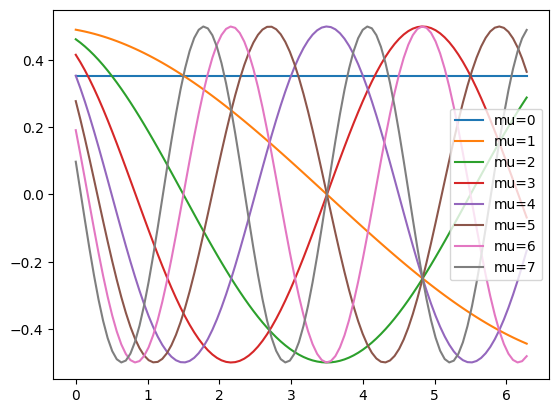

In [52]:
# def dft_basis(signal, D):
#     N = signal.shape[0]
#     coefficients = np.zeros((D, N))
#     for mu in range(D):
#         alpha = np.sqrt(1/N) if mu == 0 else np.sqrt(2/N)
#         for x in range(N):
#             coefficients[mu, x] = signal[x] * np.cos(np.pi * (2*x + 1) * mu / (2*N))
#         coefficients[mu] *= alpha
#     return coefficients


signal = np.array([1, 2, 3, 4])
D = 8
X = np.linspace(0, 2*np.pi, 100).reshape(-1, 1)
basis = np.zeros((D, X.shape[0]))
for mu in range(D):
    alpha = np.sqrt(1/D) if mu == 0 else np.sqrt(2/D)
    for i in range(X.shape[0]):
        x = X[i]
        basis[mu, i] = alpha * np.cos(np.pi * (2*x + 1) * mu / (2*D))
    plt.plot(X, basis[mu], label=f'mu={mu}')
        
basis = basis.T


# plt.plot(X, basis)
plt.legend()

## 1 c).

## 2 a).

In [53]:
coefficients = np.array([14, -3.5, 3.5, 0])
g1 = np.zeros(coefficients.shape[0])
N = coefficients.shape[0]
for x in range(coefficients.shape[0]):
    for mu in range(N):
        alpha = np.sqrt(1/N) if mu == 0 else np.sqrt(2/N)
        g1[x] += (coefficients[mu] * np.cos(np.pi * (2*x + 1) * mu / (2*N))) * alpha
        
g1

array([ 6.46351481,  4.30290682,  6.19709318, 11.03648519])

## 2 b).

In [54]:
coefficients = np.array([14, -3.5, 0, 0])
g2 = np.zeros(coefficients.shape[0])
N = coefficients.shape[0]
for x in range(coefficients.shape[0]):
    for mu in range(N):
        alpha = np.sqrt(1/N) if mu == 0 else np.sqrt(2/N)
        g2[x] += (coefficients[mu] * np.cos(np.pi * (2*x + 1) * mu / (2*N))) * alpha

In [55]:
g2

array([4.71351481, 6.05290682, 7.94709318, 9.28648519])

## 2 c).

In [56]:
g = np.array([4, 6, 8, 10])
mse1 = ((g - g1)**2).mean()
mse2 = ((g - g2)**2).mean()
print(f'{mse1=}')
print(f'{mse2=}')

mse1=np.float64(3.318451259143179)
mse2=np.float64(0.2559512591431786)


The reconstruction on the Sparse DCT coefficient actually yielded a smaller MSE

## 3 a).

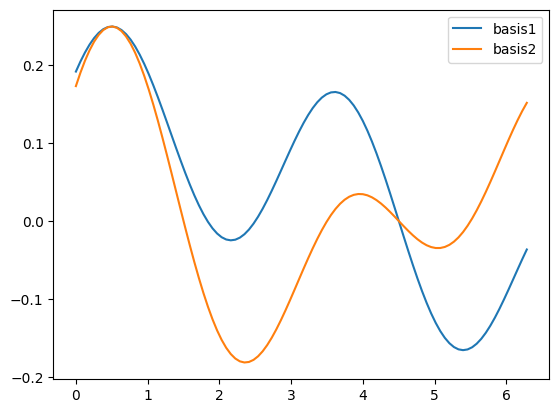

In [57]:
# case 1
u, v = 3, 4
P, Q = 8, 8
alpha = np.sqrt(1/P) if u == 1 else np.sqrt(2/P)
beta = np.sqrt(1/Q) if v == 1 else np.sqrt(2/Q)
X = np.linspace(0, 2*np.pi, 100).reshape(-1, 1)
basis1 = alpha * beta * np.cos(np.pi * (2*X - 1) * (u-1) / (2*P)) * np.cos(np.pi * (2*X - 1) * (v-1) / (2*Q))
plt.plot(X, basis1, label='basis1')

# case 2
u, v = 5, 2
alpha = np.sqrt(1/P) if u == 1 else np.sqrt(2/P)
beta = np.sqrt(1/Q) if v == 1 else np.sqrt(2/Q)
basis2 = alpha * beta * np.cos(np.pi * (2*X - 1) * (u-1) / (2*P)) * np.cos(np.pi * (2*X - 1) * (v-1) / (2*Q))
plt.plot(X, basis2, label='basis2')

plt.legend()

## 3 b).

In [58]:
G = np.array([
    [1, 2], 
    [3, 4]
])

# 1. display all basis functions
T = np.zeros((G.shape[0], G.shape[1]))
for x in range(1, G.shape[0]+1):
    for y in range(1, G.shape[1]+1):
        for u in range(1, G.shape[0]+1):
            for v in range(1, G.shape[1]+1):
                alpha = np.sqrt(1/G.shape[0]) if u == 1 else np.sqrt(2/G.shape[0])
                beta = np.sqrt(1/G.shape[1]) if v == 1 else np.sqrt(2/G.shape[1])
                # basis = alpha * beta * np.cos(np.pi * (2*X - 1) * (u-1) / (2*G.shape[0])) * np.cos(np.pi * (2*X - 1) * (v-1) / (2*G.shape[1]))
                basis = alpha * beta * np.cos(np.pi * (2*x - 1) * (u-1) / (2*G.shape[0])) * np.cos(np.pi * (2*y - 1) * (v-1) / (2*G.shape[1]))
                T[x-1, y-1] += basis
        
        # plt.plot(X, basis, label=f'basis_{u}_{v}')
        
# plt.legend()
T

array([[2.00000000e+00, 2.22044605e-16],
       [2.22044605e-16, 0.00000000e+00]])

In [59]:
# 2. compute the reconstruction of G

reconstruction = np.zeros(G.shape)
for x in range(G.shape[0]):
    for y in range(G.shape[1]):
        for u in range(1, G.shape[0]+1):
            for v in range(1, G.shape[1]+1):
                alpha = np.sqrt(1/G.shape[0]) if u == 1 else np.sqrt(2/G.shape[0])
                beta = np.sqrt(1/G.shape[1]) if v == 1 else np.sqrt(2/G.shape[1])
                reconstruction[x,y] += (alpha * beta * np.cos(np.pi * (2*x - 1) * (u-1) / (2*G.shape[0])) * np.cos(np.pi * (2*y - 1) * (v-1) / (2*G.shape[1]))) * G[u-1][v-1]
                

        
        
reconstruction

array([[5., 5.],
       [5., 5.]])

## 3 c).

# Problem 3

## 1 a).

In [60]:
from PIL import Image

img = Image.open('fishing_boat.bmp')

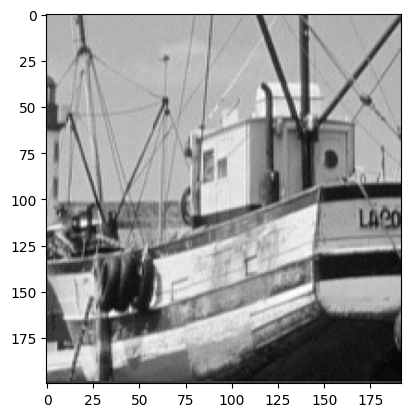

In [61]:
from matplotlib import pyplot as plt
from torchvision.transforms import transforms
# grayscale

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to 1-channel grayscale
    transforms.ToTensor()  # Convert to a PyTorch tensor
])

grayscale_image = transform(img)[0,:,:]

plt.imshow(grayscale_image, cmap='gray')

## b).

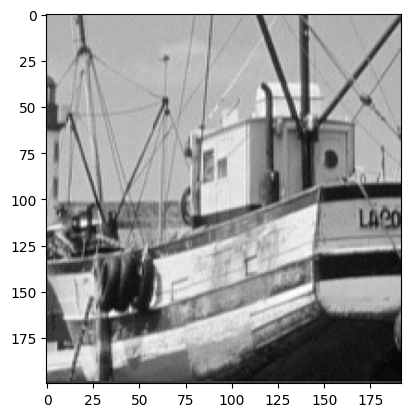

In [63]:
plt.imshow(grayscale_image, cmap='gray')


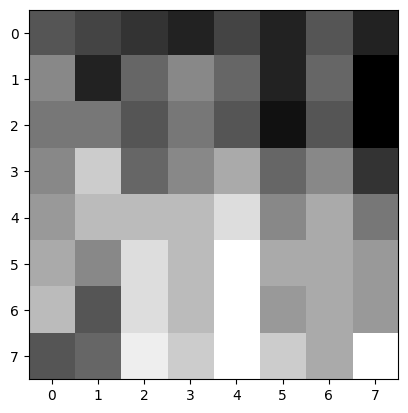

In [64]:
x = 8*3
y = 8*6
block = grayscale_image[x:x+8, y:y+8]
block.shape

plt.imshow(block, cmap='gray')

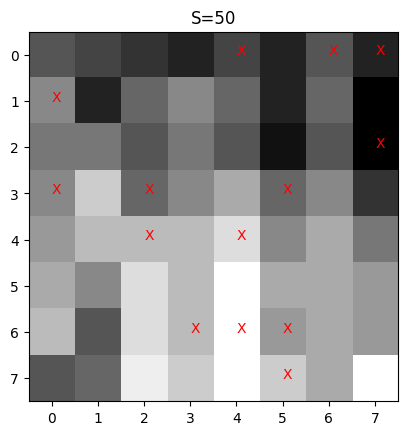

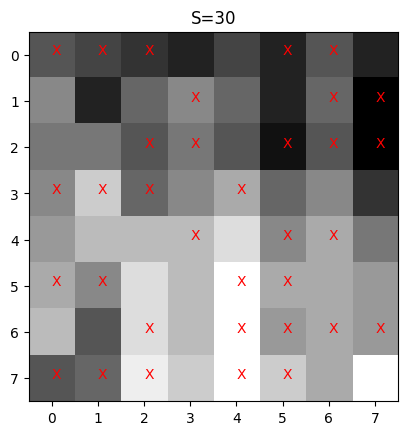

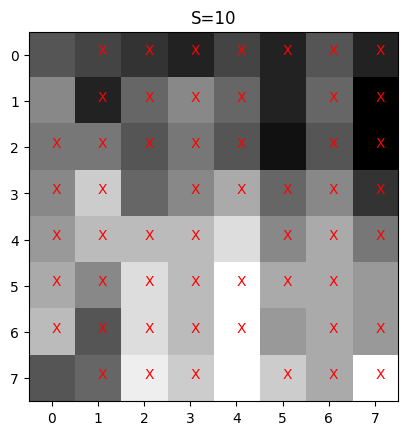

In [65]:
from numpy import random
random.seed(10)

for s in [50, 30, 10]:
    
    corrupted_block = block.clone().flatten()
    # corrupted_block[torch.randperm(64)[:64-s]] = 0.5
    pixels = torch.randperm(64)[:64-s]
    masks = torch.zeros(64)
    masks[pixels] = 1
    masks = masks.reshape(8, 8)
    
    
    plt.imshow(block, cmap='gray')
    for i in range(8):
        for j in range(8):
            if masks[i, j] == 1:
                plt.text(j, i, 'X', color='red')
    plt.title(f'S={s}')
    plt.show()

## 1 d).

## 2 a).

In [73]:
# get corrupted image
S = 30
cur = 0

c_block = block.clone()
f_block = c_block.flatten()
pixels = torch.randperm(64)[:64-S]
masks = torch.zeros(64)
masks[pixels] = 1

P, Q = 64, 64
T = np.zeros((P, Q))
# apply dct
for u in range(P):
    for v in range(Q):
        alpha = np.sqrt(1/(P*Q)) if u == 0 else np.sqrt(2/(P*Q))
        T[u, v] = alpha * np.cos(np.pi * (2*v + 1) * u / (2*P*Q))
        
# T.shape, T


In [74]:
print('Note: the lambda was chosen to be smaller than asked in the assignment because the original lambda yielded all-0 vector')
lam = 0.01
lasso = Lasso(lam)
T1 = T[masks==0]
# T2 = T1[:, masks==0]
corrupted_block = c_block.flatten()[masks == 0]
lasso.fit(T1, corrupted_block.reshape(-1, 1))
print(lasso.coef_)

Note: the lambda was chosen to be smaller than asked in the assignment because the original lambda yielded all-0 vector
[ 0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]


In [75]:
# lasso to estimate alpha

from sklearn.linear_model import Lasso
lam = 0.0000003

lasso = Lasso(lam, max_iter=2000000)
lasso.fit(T1, corrupted_block.reshape(-1, 1))
lasso.coef_

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.24677243,
        0.2906345 ,  0.17686363,  0.07700953,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -1.11822324])

In [76]:
max_mags = np.argsort(-np.abs(lasso.coef_), axis=0, )[:5]
# to u,v index
for pos in max_mags:
    print(f'u,v = {pos/8},{pos%8}, weight={lasso.coef_[pos]}')

u,v = 7.875,7, weight=-1.1182232371341951
u,v = 5.0,0, weight=0.29063450408137853
u,v = 4.875,7, weight=0.24677242953078446
u,v = 5.125,1, weight=0.17686362879903064
u,v = 5.25,2, weight=0.07700953068137688


## 2 b).

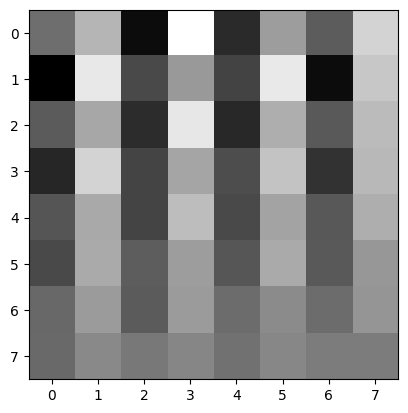

In [77]:
# reconstruct image

reconstruction = np.zeros(64)

coefs = lasso.coef_

for i in range(64):
    for j in range(64):
        alpha = np.sqrt(1/(64)) if i == 0 else np.sqrt(2/(64))
        reconstruction[i] += alpha * coefs[j] * np.cos(np.pi * (2*j + 1) * i / (2*64))

reconstruction = reconstruction.reshape(8, 8)
plt.imshow(reconstruction, cmap='gray')

## 2 c).

In [78]:
if block.device != 'cpu':
    block = block.cpu()
    reconstruction = torch.tensor(reconstruction).to(block.device)
mse = ((reconstruction - block)**2).mean()
print(f'{mse=}')

mse=tensor(0.5666, dtype=torch.float64)


## 2 d).